## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026


# Weekly Homework 2: It's shopping time! Let's discover some association rules.


***Goals of this homework:***
Learn how to find items to recommend to shoppers with association rules.


***Submission instructions:***

You should post your notebook to Canvas (look for the assignment there). Please name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that.

***Grading philosophy:***

We are grading reasoning, judgment, and clarity, not just correctness. Show us that you understand the data, the constraints, and the limits of your conclusions.

***For each question, you need to respond with 3 cells:***
1. **[A Code Cell] Your Code:** If code is not applicable, put `# no code` in the cell. For tests: tests can be simple assertions or checks (e.g., using `assert` or `print` or small functions or visual inspection); formal testing frameworks are not required.
2. **[A Markdown Cell] Your Answer:** Write up your answers and explain them in complete sentences. Include any videos in this section as well; for videos, upload them to your TAMU Google Drive, and ensure they are set to be visible by the instruction team (set to: **anyone with a TAMU email can view**), then share the link to the video in the cell.
3. **[A Markdown Cell] Your Resources:** You need to cite 3 types of resources and note how they helped you: (1) Collaborators, (2) Web Sources (e.g. StackOverflow), and (3) AI Tools (you must also describe how you prompted, but we do not require any links to any specific chats). Specifically, use the following format as a template:
```
On my honor, I declare the following resources:
1. Collaborators:
- Reveille A.: Helped me understand that a df in pandas is a data structure kinda like a CSV.
- Sully A.: Helped me fix a bug with the vector addition of 2 columns.
- ...

2. Web Sources:
- https://stackoverflow.com/questions/46562479/python-pandas-data-frame-creation: how to create a pd df
- ...

3. AI Tools:
- ChatGPT: I gave it the homework .ipynb file and the ufo.csv, and told it to generate the code for the first question, but it did it with csv.reader(), so I re-prompted it to use pandas and that one was correct
- ...
```
***Why do we require this cell?*** This cell is important...

1. For academic integrity, you must give credit where credit is due.

2. We want you to pay attention to how you can successfully get help to move through problems! Is there someone you work with or an AI tool that helps you learn the material better? That's great! The point of engineering is to use your tools to solve hard problems, and part of graduate school is learning about how *you* learn and solve problems best.

***A reminder: you get out of it what you put into it.***
Do your best on these homeworks, show us your creativity, and ask for help when you need it -- good luck!

# A [16pts]. Let's continue our EDA from HW1!

**Rubric**

[8 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[4 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


# 1.
* Load `ufos.csv` into a `pd.DataFrame()`
* Locate geospatial hotspots: Aggregate by (lat1,lon1) and list top‑20 cells. Justify a normalization (per capita proxies or surface area) if you apply one.
* Intrepret the geospatial hotspots, explain in words what you see in the results.

In [1]:
import pandas as pd
df = pd.read_csv("../data/ufos.csv", usecols=range(11), low_memory=False)
def valid_lat(latitude : float):
    return (latitude <= 90) & (latitude >= -90)
def valid_long(longitude : float):
    return (longitude <= 180) & (longitude >= -180)
def valid_location(ufo_df):
    return (valid_lat(ufo_df["latitude"])) & (valid_long(ufo_df["longitude"]))

df["latitude"]  = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df = df.dropna(subset=['latitude', 'longitude'])
df = df.loc[valid_location(df)]

hotspots = (
    df.groupby(["latitude", "longitude"])
      .size()
      .reset_index(name="sighting_count")
)

top20 = hotspots.sort_values("sighting_count", ascending=False).head(20)

print(top20)


top20_with_cities = pd.merge(
    top20,
    df[["latitude", "longitude", "city"]],
    on=["latitude", "longitude"],
    how="left"
)

# Drop duplicate city entries per hotspot
top20_with_cities = top20_with_cities.drop_duplicates(
    subset=["latitude", "longitude"]
)

# Print the cities
print(top20_with_cities[["city", "latitude", "longitude", "sighting_count"]])



        latitude   longitude  sighting_count
509     0.000000    0.000000            1494
19213  47.606389 -122.330833             627
11819  40.714167  -74.006389             600
3732   33.448333 -112.073333             511
6390   36.175000 -115.136389             417
4420   34.052222 -118.242778             414
3150   32.715278 -117.156389             384
18154  45.523611 -122.675000             362
1896   29.763056  -95.363056             328
13948  41.850000  -87.650000             323
2867   32.221667 -110.925833             264
1124   25.773889  -80.193889             255
1584   28.538056  -81.379444             246
5398   35.084444 -106.650556             237
8577   38.581667 -121.493333             230
2106   30.266944  -97.742778             227
20300  51.514125   -0.093689             223
7705   37.775000 -122.418333             209
7343   37.339444 -121.893889             199
10136  39.739167 -104.984167             193
                        city   latitude   longitude  si

normalizing by population doesn't make much sense here since the data doesn't explicitly include population data
to normalize by population density, we would probably need to find the population densities of every unique city in the dataset. 
normalizing by surface area also doesn't make sense since I am not grouping different pairs of lats / longs together, just checking for exact lat/long matches.  
From the results it looks like most of the hot spots are concentrated in North America. We can also see that either the lat/long or cities were incorrectly inputted as willow beach most definitely does not have (0, 0) as its latitude/longitude. Unfortunately I don't see how we would be able to automatically deduce which is correct. We could try to use some kind of geo locator to lookup the state at a particular latitude / longitude coordinate and discard datapoints which have a discrepancy, however, as mentioned in the last homework, this is infeasible due to the fact that geo locators are not free. 

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- ChatGPT: I asked chatgpt to create code for finding hotspots given a dataframe with the columns "latitude" and "longitude", I also asked chatgpt to generate code for showing the cities belonging to each of these hotspots.
```

# 2.
* Construct a shape × color co‑occurrence `pd.DataFrame()` named `shape_color_matrix`: First, you need to extract colors using keywords from the comments (red/orange/yellow/green/blue/purple/violet/white/black/silver/gold/pink; handle “-ish” variants). Build a co‑occurrence dataframe with shape or your normalized shape_norm. Print or display it here.
* What are the most popular shape x colors?
* What are the least popular shape x colors?

In [2]:
import re
import pandas as pd
colors = [
    "red", "orange", "yellow", "green", "blue",
    "purple", "violet", "white", "black",
    "silver", "gold", "pink"
]
color_pattern = re.compile(
    r"\b(" + "|".join(colors) + r")(?:-?ish)?\b",
    flags=re.IGNORECASE
)
def extract_colors(text):
    if pd.isna(text):
        return []
    
    matches = color_pattern.findall(text)
    
    # normalize + remove duplicates
    return list(set([m.lower() for m in matches]))
"""
pairs = df[["shape", "color_list"]].explode("color_list")
pairs = pairs.dropna(subset=["shape", "color_list"]).reset_index(drop=True)

shape_color_matrix = pd.crosstab(pairs["shape"], pairs["color_list"])
display(shape_color_matrix)
"""
df["color_list"] = df["comments"].apply(extract_colors)
pairs = df[["shape", "color_list"]].explode("color_list")
pairs = pairs.dropna(subset=["shape", "color_list"]).reset_index(drop=True)

shape_color_matrix = pd.crosstab(pairs["shape"], pairs["color_list"])
display(shape_color_matrix)



color_list,black,blue,gold,green,orange,pink,purple,red,silver,violet,white,yellow
shape,,,,,,,,,,,,
changed,0,1,0,0,0,0,0,1,0,0,0,0
changing,90,101,10,77,158,5,7,180,27,1,187,44
chevron,52,29,8,28,56,7,2,69,7,0,87,13
cigar,56,83,8,61,90,6,1,112,154,1,212,24
circle,148,395,39,419,1334,22,15,986,153,2,975,245
cone,7,13,3,12,27,2,1,24,7,0,36,7
crescent,0,0,0,0,1,0,0,0,0,0,0,0
cross,4,8,4,6,23,1,0,26,2,0,32,10
cylinder,50,48,7,44,79,8,3,87,87,0,126,28


The most popular pairs are light and white, light and red, light and orange, fireball and orange, circle and orange, sphere and orange  
The least popular pairs are delta and anything, round and anything, crescent and anything, changed and anything, pyramid and anything, unknown and violet, flash and violet

On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- ChatGPT: I just pasted the output of df.info() and the question and chatgpt generated the correct code.

# B [32pts]. Association Rules in a Sticker Dataset

**Rubric**

[8 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[4 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


Today, we're going to pretend we are data scientists at RedBubble (online sticker shop), and we need to figure out some good association rules.

For example, if I am a user who is interested in purchasing this sticker:



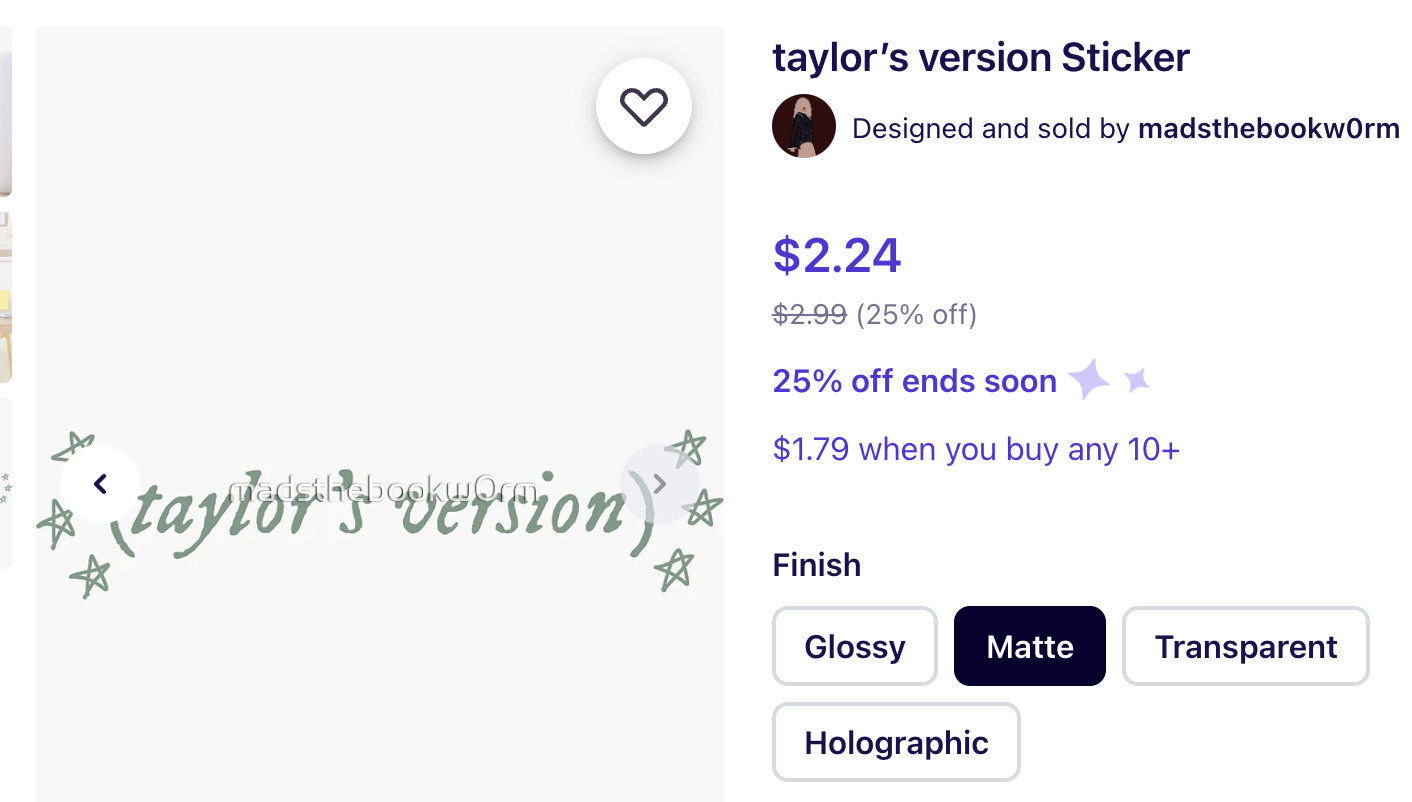

Then it behooves RedBubble to recommend these stickers to me too --

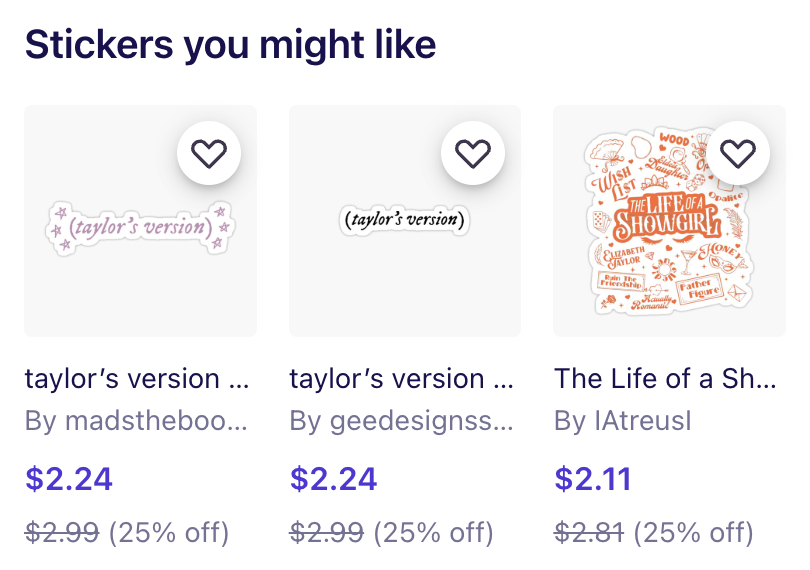

Because I'm probably also interested in those stickers too, and Redbubble wants my $$$!

So here's the problem: There are thousands and thousands of stickers on RedBubble, with thousands more added every day. We can't just eyeball which stickers to recommend to users...

We need to do some math over our sticker dataset, and figure out a way to programatically recommend relevant stickers to users in the "Stickers you might like" panel of the RedBubble website, based on the sticker they are currently looking at.

This seems like a great place to use **association rules**!

Let's work a small example on a small dataset by hand to get our function working. Let's use shorthand for the stickers in our dataset:
- F = Fearless sticker
- R = Red sticker
- S = 1989 sticker
- L = Lover sticker
- M = Midnights sticker

Here are 5 recent reciepts from some Swiftie customers:
- Receipt 1: {F, R}
- Receipt 2: {R, S}
- Receipt 3: {F, R, S}
- Receipt 4: {R, S}
- Receipt 5: {F, R, M}

# 1.
Apply the apriori algorithm, using minsup=2 and minconf=0.75.
- (1) How many frequent itemsets are there? List them all, and show all your work (e.g., List all possible 2-itemsets and their corresponding support counts, and note which are pruned/survive; report the 2-itemsets. If apriori has terminated at this point, just write "terminated.")
- (b) Write out each possible association rule, and their corresponding confidence levels, and note which are pruned/survive; report the association rules you found.
- (c) Interpret the association rules you found using business logic: how would you explain what these association rules mean to a product manager on your RedBubble team?
- (d) Confidence is not symmetric (conf(a->b) != conf(b->a)). Why do you think the algorithm designers decided to define confidence this way (not symmetric)? (You can think about: what would it mean if the confidence calculation was designed to be symmetric (conf(a->b) = conf(b->a)) -- how would that change your interpretation of the discovered rules?)

For this problem, write your work out, either in a markdown cell, or by hand + upload a picture.



(a) So the first step in Apriori is to simply count the singletons:  
F: 3  
R: 5  
S: 3  
L: 0  
M: 1  
minsup = 2 so we can already eliminate L and M as frequent item sets (and all sets that contain L or M as subsets)  
Thus we have the following sets of two to check:  
FR: 3  
FS: 1  
RS: 3  
So we can eliminate FS as a frequent item set. Apriori is terminated because there are no remaining sets of 3 which don't contain FS or L or M as subsets. Frequent item sets are:
F, R, S, FR, and RS

(b) We are only concerned with frequent item sets so possible association rules and confidence levels are:  
F -> R: 3 / 3 = 1
R -> F: 3 / 5 = .6  
R -> S: 3 / 5 = .6  
S -> R: 3 / 3 = 1  
All but the association rules S -> R and F -> R are pruned (confidence less then minconf)  

(c) I would say that the sticker S (1989 sticker) is never purchased without the sticker R (red sticker) also being purchased, i.e if sticker S is purchased, then sticker R is always purchased. This implies there might be a strong relationship between sticker S and sticker R in relation to customer buying habits.  
However I would add the caveat that R is purchased in EVERY order so maybe this relationship isn't so special after all. 

(d) It doesn't really make sense for the confidence of a rule to be symmetric. The rules A implies B and B implies A are completely different rules. For instance if we have x = 2, then x = 2 implies x^2 = 4. However x^2 = 4 does not implie that x = 2 since x could equal -2. If confidence was symmetric then that would imply that A -> B is equivalent to the rule B -> A, which as stated above doesn't make sense.



```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- https://en.wikipedia.org/wiki/Association_rule_learning - formulas for association confidence

3. AI Tools:
- None
```

# 2.
Now, let's write out the apriori algorithm in code!

```
import pandas as pd

data = {
    "receipt_id": [1, 2, 3, 4, 5],
    "items": [
        ["F", "R"],
        ["R", "S"],
        ["F", "R", "S"],
        ["R", "S"],
        ["F", "R", "M"]
    ]
}

df = pd.DataFrame(data)
```

Complete the following tasks:
- Print or display the dataframe, and answer the following questions about how the data is structured: what are the rows? What are the columns? How do you print which items are part of receipt 1, receipt 2, etc.?
- Write a function called `apriori_list_format(data, debug, minsup, minconf)` that takes in `data` shown above, `debug` as described next, `minsup` and `minconf` with the values from the previous question, and outputs the association rules (you can choose the data format for the output).
- Your function should include a boolean `debug` parameter that allows you to see what is happening in your function at each important step -- here, some important steps are: the itemset calculations, the minsup comparison, what is pruned/survivies, etc. The purpose of this step is to help you check that your code matches your work from the previous question. Because -- *if you can see what is happening, you can debug what is happening!*
- Run your function in debug mode with `data` and the same parameters from the previous question, to show us that your function works.

In [3]:
import pandas as pd
import copy
data = {
    "receipt_id": [1, 2, 3, 4, 5],
    "items": [
        ["F", "R"],
        ["R", "S"],
        ["F", "R", "S"],
        ["R", "S"],
        ["F", "R", "M"]
    ]
}

df = pd.DataFrame(data)
display(df)
def get_unique_items(itemsets):
    result = []
    for i in range(0, len(itemsets)):
        for j in range(0, len(itemsets[i])):
            if not (itemsets[i][j] in result):
                result.append(itemsets[i][j])
    return result
    
def collect_freq_itemsets(data, debug, minsup, minconf, itemset_size, frequent_itemsets):
    items = data["items"]
    candidates = []
    frequent_itemsets[itemset_size] = []
    #generate possible candidates for this iteration
    if(itemset_size > 1):
        prev_freq_sets = frequent_itemsets[itemset_size - 1]
        unique_singles = get_unique_items(prev_freq_sets)
        for itemset in prev_freq_sets:
            for character in unique_singles:
                if character in itemset:
                    continue
                new_itemset = copy.deepcopy(itemset)
                new_itemset += character
                new_itemset = ''.join(sorted(new_itemset))
                if new_itemset in candidates:
                    continue
                candidates.append(new_itemset)
                if(debug):
                    print("adding ", new_itemset, " as a candidate freq item list")
    else:
        candidates = get_unique_items(items)
    
    if(len(candidates) == 0):
        return;
        
    candidate_frequencies = {}
    
    for candidate in candidates:
        candidate_frequencies[candidate] = 0
    for set_of_items in items:
        for candidate in candidates:
            worked = True;
            for item in candidate:
                if not (item in set_of_items):
                    worked = False
                    break
            if(worked):
               candidate_frequencies[candidate] += 1

    for candidate, frequency in candidate_frequencies.items():
        if(frequency > minsup):
            frequent_itemsets[itemset_size].append(candidate)
            if(debug):
                print("Candidate ", candidate, " identified ass frequent itemset with frequency ", frequency)
        else:
            if(debug):
                print("Removing candidate ", candidate, " from pool of frequent itemsets")
    collect_freq_itemsets(data, debug, minsup, minconf, itemset_size+1, frequent_itemsets)    

class Association_Rule:
    def __init__(self, precedent, antecedent):
        self.precedent = precedent
        self.antecedent = antecedent

    def __str__(self):
        return self.precedent + " -> " + self.antecedent

def generate_association_rule_from_string(my_string, index, antecedent, precedent):
    if(index >= len(my_string)):
        return [Association_Rule(precedent, antecedent)]

    #we can choose to either add this letter to the precedent, or add it the antecedent
    precedent += my_string[index]
    precedent_result = generate_association_rule_from_string(my_string, index + 1, antecedent, precedent)
    precedent = precedent[:-1]
    antecedent += my_string[index]
    antecedent_result = generate_association_rule_from_string(my_string, index + 1, antecedent, precedent)
    antecedent = antecedent[:-1]
    return precedent_result + antecedent_result
    
def generate_association_rules(frequent_itemsets):
    association_rules = []
    for length, itemsets in frequent_itemsets.items():
        for itemset in itemsets:
            association_rules += generate_association_rule_from_string(itemset, 0, "", "")
    #remove all association rules without precedent or without antecedent
    i = 0
    while(i < len(association_rules)):
        rule = association_rules[i]
        if(not rule.precedent or not rule.antecedent):
            del association_rules[i]
            continue;
        i += 1
    return association_rules
    
def contains_string(base_string, sub_string):
    for char in sub_string:
        if not (char in base_string):
            return False
    return True

def calculate_confidence(association_rule, data):
    items = data["items"]
    antecedent = association_rule.antecedent
    precedent = association_rule.precedent
    union = antecedent + precedent
    precedent_count = 0
    union_count = 0;
    for item in items:
        if(contains_string(item, union)):
            union_count += 1
        if(contains_string(item, precedent)):
            precedent_count += 1
    if(union_count == 0):
        return 0
    return union_count / precedent_count
    
def apriori_list_format(data, debug, minsup, minconf):
    #I much prefer working with dictionaries rather than dataframes because if i want to do anything with a dataframe i have to scroll through documentation for 15 minutes or ask chatgpt
    #anyways...
    frequent_itemsets = {}
    collect_freq_itemsets(data, debug, minsup, minconf,1, frequent_itemsets)
    if(debug):
        print("Final Frequent Itemsets:")
        print(frequent_itemsets)
    association_rules = generate_association_rules(frequent_itemsets)
    if(debug):
        print("Generated Association Rules:")
        for rule in association_rules:
            print(rule)
    if(debug):
        for rule in association_rules:
            print("rule ", rule, " has confidence: ", calculate_confidence(rule, data))
    
    print("Final Association Rules")
    for rule in association_rules:
        confidence = calculate_confidence(rule, data)
        if(confidence > minconf):
            print("rule ", rule, " has confidence: ", calculate_confidence(rule, data))
    
        

apriori_list_format(data, True, 2, .75)

,receipt_id,items
0,1,"[F, R]"
1,2,"[R, S]"
2,3,"[F, R, S]"
3,4,"[R, S]"
4,5,"[F, R, M]"


Candidate  F  identified ass frequent itemset with frequency  3
Candidate  R  identified ass frequent itemset with frequency  5
Candidate  S  identified ass frequent itemset with frequency  3
Removing candidate  M  from pool of frequent itemsets
adding  FR  as a candidate freq item list
adding  FS  as a candidate freq item list
adding  RS  as a candidate freq item list
Candidate  FR  identified ass frequent itemset with frequency  3
Removing candidate  FS  from pool of frequent itemsets
Candidate  RS  identified ass frequent itemset with frequency  3
adding  FRS  as a candidate freq item list
Removing candidate  FRS  from pool of frequent itemsets
Final Frequent Itemsets:
{1: ['F', 'R', 'S'], 2: ['FR', 'RS'], 3: [], 4: []}
Generated Association Rules:
F -> R
R -> F
R -> S
S -> R
rule  F -> R  has confidence:  1.0
rule  R -> F  has confidence:  0.6
rule  R -> S  has confidence:  0.6
rule  S -> R  has confidence:  1.0
Final Association Rules
rule  F -> R  has confidence:  1.0
rule  S -> 

The rows are purchases, the columns are receipt id and items. You could just go row by row to print the receipt id with its corresponding item. If you wanted to print a specific receipt id i, you would print the i - 1 row. e.g if receipt id was 1 you would print the row indexed at 0.

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- https://stackoverflow.com/questions/69205854/iterating-over-dictionary-in-python-and-using-each-value - I forgot how to iterate over dictionary in Python
- https://www.reddit.com/r/learnpython/comments/lizzdx/how_to_sort_a_string_alphabetically/ - help sorting strings

3. AI Tools:
- None
```


# 3.
Now, let's write out the apriori algorithm in code -- again! With a different data format. This data format is actually much more common, and it's the one you'll see most often.

```
import pandas as pd

df_binary = pd.DataFrame({
    "F": [1, 0, 1, 0, 1],
    "R": [1, 1, 1, 1, 1],
    "S": [0, 1, 1, 1, 0],
    "M": [0, 0, 0, 0, 1]
}, index=[1, 2, 3, 4, 5])

df_binary.index.name = "receipt_id"
```

Complete the following tasks:
- Print or display the dataframe, and answer the following questions about how the data is structured: what are the rows? What are the columns? How do you print which items are part of receipt 1, receipt 2, etc.?
- Write a function called `apriori_binary_format(data, debug, minsup, minconf)` that takes in `data` shown above, `debug` as described next, `minsup` and `minconf` with the values from Q1, and outputs the association rules (you can choose the data format for the output).
- Your function should include a boolean `debug` parameter that allows you to see what is happening in your function at each important step -- here, some important steps are: the itemset calculations, the minsup comparison, what is pruned/survivies, etc. The purpose of this step is to help you check that your code matches your work from Q1. Because -- *if you can see what is happening, you can debug what is happening!*
- Run your function in debug mode with `data` and the same parameters from Q1, to show us that your function works.

In [4]:
data = {
    "F": [1, 0, 1, 0, 1],
    "R": [1, 1, 1, 1, 1],
    "S": [0, 1, 1, 1, 0],
    "M": [0, 0, 0, 0, 1]
}
import pandas as pd
class Association_Rule_List:
    def __init__(self, precedent, antecedent):
        self.precedent = precedent
        self.antecedent = antecedent

    def __str__(self):
        return "[" + ','.join(self.precedent) + "] -> [" + ','.join(self.antecedent) + "]"
df_binary = pd.DataFrame(data, index=[1, 2, 3, 4, 5])

df_binary.index.name = "receipt_id"
display(df_binary)

def collect_freq_itemsets_binary(data, debug, minsup, minconf, itemset_size, frequent_itemsets, num_rows):
    candidates = []
    frequent_itemsets[itemset_size] = []
    #generate possible candidates for this iteration, same as non binary
    if(itemset_size > 1):
        prev_freq_sets = frequent_itemsets[itemset_size - 1]
        unique_singles = get_unique_items(prev_freq_sets)
        for itemset in prev_freq_sets:
            for character in unique_singles:
                if character in itemset:
                    continue
                new_itemset = copy.deepcopy(itemset)
                new_itemset.append(character)
                new_itemset = ','.join(sorted(new_itemset))
                if new_itemset in candidates:
                    continue
                candidates.append(new_itemset)
                if(debug):
                    print("adding ", new_itemset, " as a candidate freq item list")
    else:
        candidates = list(data.keys())
    
    if(len(candidates) == 0):
        return;
        
    candidate_frequencies = {}
    
    for candidate in candidates:
        candidate_frequencies[candidate] = 0

    for i in range(0, num_rows):
        for candidate in candidates:
            worked = True
            candidate_list = candidate.split(",")
            for item in candidate_list:
                if(item == ""):
                    continue
                if(not (data[item][i])):
                    worked = False
                    break;
            if(worked):
                candidate_frequencies[candidate] += 1

    for candidate, frequency in candidate_frequencies.items():
        if(frequency > minsup):
            frequent_itemsets[itemset_size].append(candidate.split(","))
            if(debug):
                print("Candidate ", candidate, " identified ass frequent itemset with frequency ", frequency)
        else:
            if(debug):
                print("Removing candidate ", candidate, " from pool of frequent itemsets")
    collect_freq_itemsets_binary(data, debug, minsup, minconf, itemset_size+1, frequent_itemsets, num_rows) 

def calculate_confidence_binary(rule, data, num_rows):
    
    antecedent = rule.antecedent
    precedent = rule.precedent
    union = antecedent + precedent
    precedent_count = 0
    union_count = 0;
    for i in range(0, num_rows):
        contains_union = True
        for character in union:
            if not data[character][i]:
                contains_union = False
                break;
        if(contains_union):
            union_count += 1

        contains_precedent = True
        for character in precedent:
            if not data[character][i]:
                contains_precedent = False
                break;
        if(contains_precedent):
            precedent_count += 1
            
    if(union_count == 0):
        return 0
    return union_count / precedent_count

def generate_association_rules_binary_rec(frequent_itemset, index, precedent, antecedent):
    if(index >= len(frequent_itemset)):
        return [Association_Rule_List(precedent.copy(), antecedent.copy())]

    #either add to precedent or antecedent
    precedent.append(frequent_itemset[index])
    precedent_result = generate_association_rules_binary_rec(frequent_itemset, index + 1, precedent, antecedent)
    precedent.pop()
    antecedent.append(frequent_itemset[index])
    antecedent_result = generate_association_rules_binary_rec(frequent_itemset, index + 1, precedent, antecedent)
    antecedent.pop()
    return precedent_result + antecedent_result
    
def generate_association_rules_binary(frequent_itemsets):
    association_rules = []
    for length, itemsets in frequent_itemsets.items():
        for itemset in itemsets:
            association_rules += generate_association_rules_binary_rec(itemset, 0, [], [])
    final_rules = []
    for rule in association_rules:
        if(not (rule.antecedent == [] or rule.precedent == [])):
            final_rules.append(rule)
    return final_rules
    
def apriori_binary_format(data, debug, minsup, minconf):
    num_rows = 0
    for key, value in data.items():
        num_rows = max(num_rows, len(value))
    
    frequent_itemsets = {}
    collect_freq_itemsets_binary(data, debug, minsup, minconf, 1, frequent_itemsets, num_rows)
    if(debug):
        print(frequent_itemsets)

    association_rules = generate_association_rules_binary(frequent_itemsets)
    if(debug):
        print("Generated Association Rules:")
        for rule in association_rules:
            print(rule)
            
    if(debug):
        for rule in association_rules:
            print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    
    print("Final Association Rules")
    confidences = []
    for rule in association_rules:
        confidence = calculate_confidence_binary(rule, data, num_rows)
        confidences.append(confidence)
        if(confidence > minconf):
            if(debug):
                print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    return association_rules, confidences
    
apriori_binary_format(data, True, 2, .75)

,F,R,S,M
receipt_id,,,,
1,1,1,0,0
2,0,1,1,0
3,1,1,1,0
4,0,1,1,0
5,1,1,0,1


Candidate  F  identified ass frequent itemset with frequency  3
Candidate  R  identified ass frequent itemset with frequency  5
Candidate  S  identified ass frequent itemset with frequency  3
Removing candidate  M  from pool of frequent itemsets
adding  F,R  as a candidate freq item list
adding  F,S  as a candidate freq item list
adding  R,S  as a candidate freq item list
Candidate  F,R  identified ass frequent itemset with frequency  3
Removing candidate  F,S  from pool of frequent itemsets
Candidate  R,S  identified ass frequent itemset with frequency  3
adding  F,R,S  as a candidate freq item list
Removing candidate  F,R,S  from pool of frequent itemsets
{1: [['F'], ['R'], ['S']], 2: [['F', 'R'], ['R', 'S']], 3: [], 4: []}
Generated Association Rules:
[F] -> [R]
[R] -> [F]
[R] -> [S]
[S] -> [R]
rule  [F] -> [R]  has confidence:  1.0
rule  [R] -> [F]  has confidence:  0.6
rule  [R] -> [S]  has confidence:  0.6
rule  [S] -> [R]  has confidence:  1.0
Final Association Rules
rule  [F] -

([<__main__.Association_Rule_List at 0x73af4d22ea00>,
 [1.0, 0.6, 0.6, 1.0])

The rows are receipt ids and their respective one hot encodings representing which items were bought (1 for yes, 0 for no). The columns are the different unique items, if a column has a 1, it means the item was purchased, a 0 means the item was not purchased. For a given receipt id, you would iterate through the columns. If a column value is 1, then you print the column header belonging to that column. 

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- https://stackoverflow.com/questions/69205854/iterating-over-dictionary-in-python-and-using-each-value - I forgot how to iterate over dictionary in Python
- https://www.reddit.com/r/learnpython/comments/lizzdx/how_to_sort_a_string_alphabetically/ - help sorting strings

3. AI Tools:
- None
```

# 4.
Now, go find an existing Python library that *already has a function to run apriori and return association rules.*
- Run it on `df_binary` (it is OK if you need to convert it from a `pd.DataFrame` to some other format to use the function) with the same minsup and minconf and print your discovered rules here.


In [5]:
from mlxtend.frequent_patterns import apriori, association_rules

# Run Apriori to find frequent itemsets
frequent_itemsets = apriori(
    df_binary,
    min_support=.4,
    use_colnames=True
)

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.75
)

print(rules)

  antecedents consequents  antecedent support  consequent support  support  \
0         (F)         (R)                 0.6                 1.0      0.6   
1         (S)         (R)                 0.6                 1.0      0.6   

   confidence  lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0   1.0               1.0       0.0         inf            0.0   
1         1.0   1.0               1.0       0.0         inf            0.0   

   jaccard  certainty  kulczynski  
0      0.6        0.0         0.8  
1      0.6        0.0         0.8  


/home/keegan-smith/coding/school/CSCE676/venv/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/keegan-smith/coding/school/CSCE676/venv/lib/python3.9/site-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- I just asked chatgpt to do this problem, and it did it without issue. 
```

# C [36pts]. Association Rules in a Large Movie Dataset


**Rubric**

[6 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[3 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


First, run the next few cells to load the MovieLens dataset:

In [6]:
import urllib3
import zipfile
import pandas as pd
http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

In [7]:
!ls ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In [8]:
# read user ratings
movielens_df = pd.read_csv("ml-latest-small/ratings.csv")
display(movielens_df)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Look at the `movielens_df`. In this dataset, there are four **columns**:
1. `userId` is the integer ids of users,
2. `movieId` is the integer ids of movies
3. `rating` is the rate of the user gives to the movie
4. `timestamp` (we ignore in this hw)

Each **row** tells you the score that user `userId` gave to movie `movieId`.

Hmm... This doesn't look like either of the dataframes from Part B!

# 1.
Convert the `movielens_df` to binary format, and run your `apriori_binary_format` function on it. Try a few different minconf values, and print out the association rules you find.

A few details:
- For this question, treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket
- A rating >= 3 gets mapped to a 1, else map it to a 0
- Set minsup = 80 (out of 600 users/baskets)
- Pick a minconf value (you should try a few) on your own, and print your final association rules in the following format:

**movie_name_1, movie_name_2, ... -->
movie_name_k**

where the movie names can be fetched by joining the movieId with the file `movies.csv`. For example, one rule that you might find is:

**Matrix, The (1999),  Star Wars: Episode V - The Empire Strikes Back (1980),  Star Wars: Episode IV - A New Hope (1977),  ->
Star Wars: Episode VI - Return of the Jedi (1983)**

In [9]:
import pandas as pd
movies_df = pd.read_csv("ml-latest-small/movies.csv")
movie_id_to_title = dict(
    zip(movies_df["movieId"].astype(str), movies_df["title"])
)
def get_movie_name(movie_id):
    return movie_id_to_title.get(str(movie_id), f"Unknown movie {movie_id}")
# 1) Make binary rating
df = movielens_df.copy()
df["bin"] = (df["rating"] >= 3).astype(int)

# 2) user as basket: build user x movie binary matrix
# If a user rated a movie multiple times, take max (so any >=3 counts as 1)
user_movie = (
    df.groupby(["userId", "movieId"])["bin"]
      .max()
      .unstack(fill_value=0)
)

num_users = user_movie.shape[0]
print("num_users:", num_users, "num_movies:", user_movie.shape[1])

minsup = 80
minconf = .95
# 4) Convert to your expected dict format: item -> list of 0/1 across users
data = {str(movie_id): user_movie[movie_id].tolist() for movie_id in user_movie.columns}
associate_rules, confidences = apriori_binary_format(data, False, minsup, minconf)
i = 0
result = ""
count = 0
while(i < len(associate_rules)):
    confidence = confidences[i]
    if(confidence < minconf):
        i += 1
        continue
    rule = associate_rules[i]
    for movie_id in rule.precedent:
        result += get_movie_name(movie_id) + ", "
    result += " -> "
    for movie_id in rule.antecedent:
        result += get_movie_name(movie_id) + ", "
    result += "\n";
    i += 1
    count += 1
print("total # association rules: ", count)
print(result)


num_users: 610 num_movies: 9724
Final Association Rules
total # association rules:  278
Godfather: Part II, The (1974),  -> Godfather, The (1972), 
Star Wars: Episode VI - Return of the Jedi (1983), Twelve Monkeys (a.k.a. 12 Monkeys) (1995),  -> Star Wars: Episode IV - A New Hope (1977), 
Star Wars: Episode V - The Empire Strikes Back (1980), Seven (a.k.a. Se7en) (1995),  -> Star Wars: Episode IV - A New Hope (1977), 
Star Wars: Episode VI - Return of the Jedi (1983), Seven (a.k.a. Se7en) (1995),  -> Star Wars: Episode IV - A New Hope (1977), 
Star Wars: Episode VI - Return of the Jedi (1983), Seven (a.k.a. Se7en) (1995),  -> Star Wars: Episode V - The Empire Strikes Back (1980), 
Saving Private Ryan (1998), Seven (a.k.a. Se7en) (1995),  -> Matrix, The (1999), 
Seven (a.k.a. Se7en) (1995), Lord of the Rings: The Fellowship of the Ring, The (2001),  -> Matrix, The (1999), 
Godfather: Part II, The (1974), Usual Suspects, The (1995),  -> Godfather, The (1972), 
Star Wars: Episode VI - Ret

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- I asked chatgpt to write the code for converting the dataframe to the expected binary format
```

# 2.
Pick 1-2 association rules from the previous question. Copy-paste them below, and interpret what they mean, like you're a data scientist at Netflix and you need to talk to the product manager about how to change the website based on your analysis.

We have the association rule Pulp Fiction (1994), Shawshank Redemption, The (1994), Godfather, The (1972), -> Silence of the Lambs, The (1991). Silence of the lambs isn't a super popular film to rate, so this relationship might be worth digging into. 

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- None
```

# 3.
Create a plot based on the results of running your function `apriori_binary_df` multiple times with different `minconf` values:
- X-Axis: `minconf` (choose at least 3 values to try)
- Y-Axis: # of Association Rules Generated

Answer the following:
- What happens when you increase `minconf`?
- What happens when you decrease `minconf`?
- Why do you think this is the case? Explain.

/home/keegan-smith/coding/school/CSCE676/venv/lib/python3.9/site-packages/matplotlib/_fontconfig_pattern.py:64: PyparsingDeprecationWarning: 'oneOf' deprecated - use 'one_of'
  prop = Group((name + Suppress("=") + comma_separated(value)) | oneOf(_CONSTANTS))
/home/keegan-smith/coding/school/CSCE676/venv/lib/python3.9/site-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/keegan-smith/coding/school/CSCE676/venv/lib/python3.9/site-packages/matplotlib/_fontconfig_pattern.py:89: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/home/keegan-smith/coding/school/CSCE676/venv/lib/python3.9/site-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/keegan-smith/coding/school/CSCE676/venv/lib/python3.9/site-packages/matplotlib

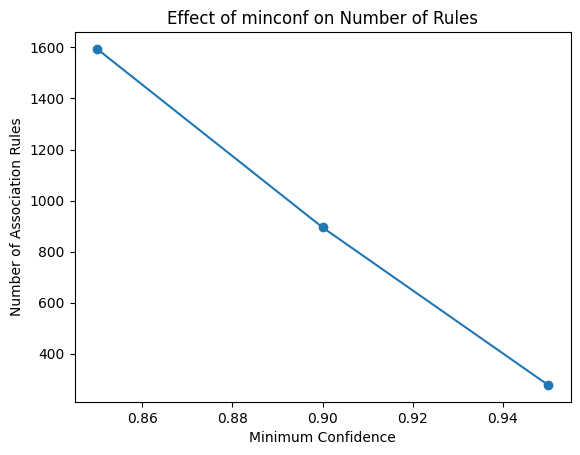

In [10]:
minconf = [.85, .9, .95]
num_rules = [1594, 895, 278]
import matplotlib.pyplot as plt

minconf = [0.85, 0.9, 0.95]
num_rules = [1594, 895, 278]

plt.figure()
plt.plot(minconf, num_rules, marker="o")

plt.xlabel("Minimum Confidence")
plt.ylabel("Number of Association Rules")
plt.title("Effect of minconf on Number of Rules")

plt.show()


As minconf increases, the number of association rules decreases.  
As minconf decreases, the number of association rules increases.  
This is the case because the total number of associations generated will be the same, you are just changing the threshold for which associations can be considered as rules.

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- I used chatgpt to generate the plot
```

# 4.

Now, create a new function `apriori_random_sampling`, where you **implement random sampling as part of the apriori algorithm**:
- Start by copy-pasting `apriori_binary_df` and renaming it :)
- We discussed random sampling in class, which is a version of apriori where you randomly sample a subset of baskets (instead of working on the whole dataset with all of the baskets) to avoid the overhead of reading the entire set of baskets (which in practice, could amount to billions(!!!) of baskets). For this part, you should implement such a random sampling approach that takes a special parameter **alpha** that controls the size of the sample: e.g., alpha = 0.10 means to sample 10% of the baskets (our users, in this case).

Create a plot based on the results of running your function `apriori_random_sampling` multiple times with different `alpha` values:
- X-Axis: `alpha` (choose at least 3 values to try)
- Y-Axis: Total # of Association Rules Generated

Answer the following:
- What happens when you increase `alpha`?
- What happens when you decrease `alpha`?
- Why do you think this is the case? Explain.

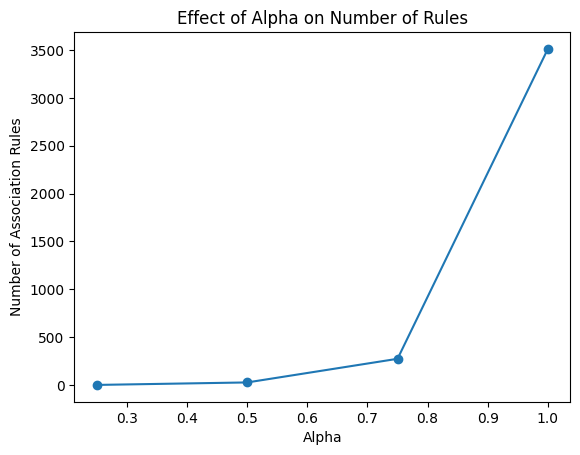

In [11]:
import random
def random_sample(data, alpha, num_rows):
    total_result_size = alpha * num_rows
    i = 0;
    used_indices = []
    while(i < total_result_size):
        index = random.randint(0, num_rows - 1)
        while(index in used_indices):
            index = random.randint(0, num_rows - 1)

        used_indices.append(index)
        i += 1

    sampled_data = {}
    for key, values in data.items():
        sampled_data[key] = [values[i] for i in used_indices]

    return sampled_data        
    
def apriori_random_sampling(data_raw, debug, minsup, minconf, alpha):
    num_rows = 0
    for key, value in data_raw.items():
        num_rows = max(num_rows, len(value))

    data = random_sample(data_raw, alpha, num_rows)
    num_rows = 0
    for key, value in data.items():
        num_rows = max(num_rows, len(value))
    print("num rows is: ", num_rows)
    frequent_itemsets = {}
    collect_freq_itemsets_binary(data, debug, minsup, minconf, 1, frequent_itemsets, num_rows)
    if(debug):
        print(frequent_itemsets)

    association_rules = generate_association_rules_binary(frequent_itemsets)
    if(debug):
        print("Generated Association Rules:")
        for rule in association_rules:
            print(rule)
            
    if(debug):
        for rule in association_rules:
            print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    
    print("Final Association Rules")
    confidences = []
    for rule in association_rules:
        confidence = calculate_confidence_binary(rule, data, num_rows)
        confidences.append(confidence)
        if(confidence > minconf):
            if(debug):
                print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    return association_rules, confidences

def print_num_association_rules(minsup, minconf, alpha):
    
    associate_rules, confidences = apriori_random_sampling(data, False, minsup, minconf, alpha)
    i = 0
    result = ""
    count = 0
    while(i < len(associate_rules)):
        confidence = confidences[i]
        if(confidence < minconf):
            i += 1
            continue
        rule = associate_rules[i]
        for movie_id in rule.precedent:
            result += get_movie_name(movie_id) + ", "
        result += " -> "
        for movie_id in rule.antecedent:
            result += get_movie_name(movie_id) + ", "
        result += "\n";
        i += 1
        count += 1
    print("total # association rules: ", count)        


alphas = [.25, .5, .75, 1]
num_association_rules = [0, 26, 273, 3511]
plt.figure()
plt.plot(alphas, num_association_rules, marker="o")

plt.xlabel("Alpha")
plt.ylabel("Number of Association Rules")
plt.title("Effect of Alpha on Number of Rules")

plt.show()

When you increase alpha, the number of associations increases.  
When you decrease alpha, the number of associations decreases.  
This is the case because we are keeping minsup constant. Thus the total number of frequent itemsets is going to be much smaller for small alpha. Less frequent itemsets necessarily implies less association rules since association rules are derived from frequent itemsets.

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- I used Chatgpt to help with random sampling
```

# 5.

Now, let's see how `alpha` impacts the **total # of itemsets** generated!

Create a new version of your `apriori_random_sampling` function called `apriori_random_sampling_with_itemsets`, which also returns the total # of itemsets.

Create a plot based on the results of running your function `apriori_random_sampling` multiple times with different `alpha` values:
- X-Axis: `alpha` (choose at least 3 values to try, including `alpha=1.0` -- the entire dataset)
- Y-Axis: Total # of Itemsets Generated

Answer the following:
- What happens when you increase `alpha`?
- What happens when you decrease `alpha`?
- Why do you think this is the case? Explain.

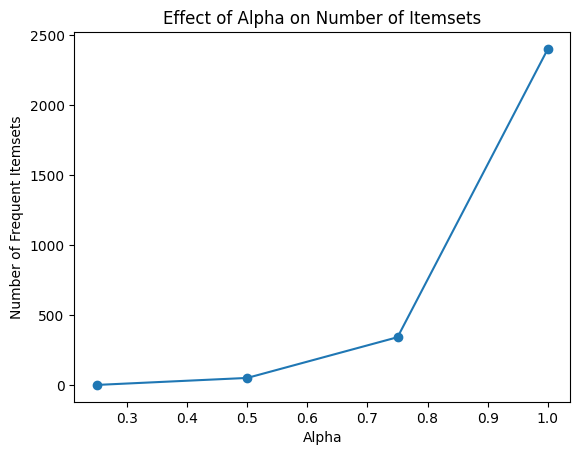

In [12]:
import matplotlib.pyplot as plt
def apriori_random_sampling_with_itemsets(data_raw, debug, minsup, minconf, alpha):
    num_rows = 0
    for key, value in data_raw.items():
        num_rows = max(num_rows, len(value))

    data = random_sample(data_raw, alpha, num_rows)
    num_rows = 0
    for key, value in data.items():
        num_rows = max(num_rows, len(value))
    print("num rows is: ", num_rows)
    frequent_itemsets = {}
    collect_freq_itemsets_binary(data, debug, minsup, minconf, 1, frequent_itemsets, num_rows)
    total_count = 0;
    frequent_itemsets_list = []
    for key, values in frequent_itemsets.items():
        frequent_itemsets_list += values
        total_count += len(values)
    if(debug):
        print(frequent_itemsets)

    association_rules = generate_association_rules_binary(frequent_itemsets)
    if(debug):
        print("Generated Association Rules:")
        for rule in association_rules:
            print(rule)
            
    if(debug):
        for rule in association_rules:
            print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    
    print("Final Association Rules")
    confidences = []
    for rule in association_rules:
        confidence = calculate_confidence_binary(rule, data, num_rows)
        confidences.append(confidence)
        if(confidence > minconf):
            if(debug):
                print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    return association_rules, confidences, total_count, frequent_itemsets_list

#association_rules, confidences, total_count, frequent_itemsets_list = apriori_random_sampling_with_itemsets(data, False, 80, .75, 1)
#print("total num freq itemsets: ", total_count)

alphas = [.25, .5, .75, 1]
num_itemsets = [0, 50, 341, 2401]
plt.figure()
plt.plot(alphas, num_itemsets, marker="o")

plt.xlabel("Alpha")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Effect of Alpha on Number of Itemsets")

plt.show()

When you increase alpha, the number of itemsets generated increases.  
When you decrease alpha, the number of itemsets generated decreases.  
This makes sense since decreasing the size of the dataset makes it much less likely that any itemset is going to have support > 80. Again since support is at the fixed constant 80. 

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- None
```

# 6.
Now, let’s see how `minsup_sample` impacts false positives! Set `alpha=0.50` for this question so we can just focus on what happens when you change the value of `minsup_sample`.

Create a new version of `apriori_random_sampling_with_itemsets` called `apriori_random_sampling_with_itemsets_and_fps`, which also returns the number of false positives found in the sampled version of the dataset (as compared to the entire dataset).

Create a plot based on the results of running your function multiple times with different `minsup_sample` values:

* X-Axis:
  * minsup_sample (choose at least 3 values to try)
* Y-Axis (plot both and use a legend):
  * Total # of frequent itemsets found in the sample
  * Total # of false positives (itemsets frequent in the sample but not frequent in the full dataset)

Answer the following:
- What happens to the number of false positives when you increase `minsup_sample`?
- What happens to the number of false positives when you decrease `minsup_sample`?
- Why do you think this is the case? Explain.

Hint: A smaller support threshold (`minsup_sample`) makes it easier for noisy patterns to appear frequent.

false positives:  213


Text(0.5, 1.0, 'Effect of minsup_sample on False Positives')

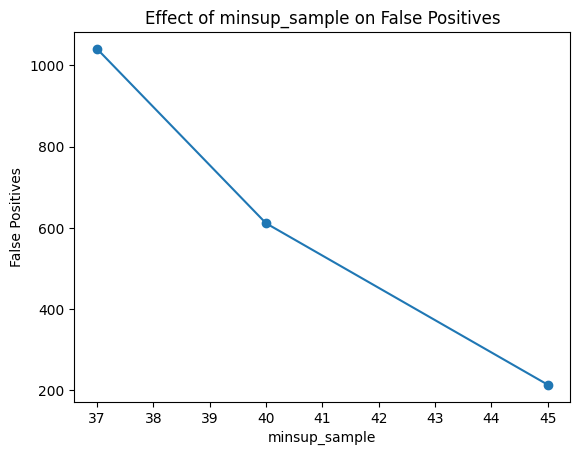

In [30]:
#I'm assuming minsup_sample is supposed to be the minsup for just the randomized algorithm
#We will compare this to the full dataset with minsup = 80 
def num_false_positives(data_raw, sample_frequent_itemsets, debug, minsup, minconf, alpha):
    # Count rows in full dataset
    num_rows = 0
    for _, value in data_raw.items():
        num_rows = max(num_rows, len(value))

    # Mine "true" frequent itemsets on the full dataset
    frequent_itemsets = {}
    collect_freq_itemsets_binary(data_raw, debug, minsup, minconf, 1, frequent_itemsets, num_rows)
    print("finished collecting frequent itemsets")
    # Helper: turn whatever container we have into a set of hashable itemsets
    def to_itemset_set(obj):
        """
        Supports:
          - list/tuple/set of itemsets
          - dict mapping itemset -> something (e.g., support)
        Returns: set of itemsets as tuples (sorted) for stable membership tests.
        """
        if obj is None:
            return set()

        # If it's a dict like {itemset: support}
        if isinstance(obj, dict):
            keys = obj.keys()
        else:
            keys = obj

        out = set()
        for it in keys:
            # itemset might already be a tuple/frozenset/etc.
            if isinstance(it, (set, frozenset, list)):
                out.add(tuple(sorted(it)))
            elif isinstance(it, tuple):
                out.add(tuple(sorted(it)))
            else:
                # single item case (rare) -> treat as 1-item itemset
                out.add((it,))
        return out

    false_positives = 0
    total_sample_itemsets = 0

    # Compare sample frequent itemsets against full-data frequent itemsets
    for length, itemsets in sample_frequent_itemsets.items():
        sample_set = to_itemset_set(itemsets)
        full_set = to_itemset_set(frequent_itemsets.get(length, []))

        total_sample_itemsets += len(sample_set)
        for it in sample_set:
            if it not in full_set:
                false_positives += 1
                if debug:
                    print(f"False positive (len={length}): {it}")

    if debug:
        print(f"Total sample frequent itemsets: {total_sample_itemsets}")
        print(f"False positives: {false_positives}")

    return false_positives
        
    
def apriori_random_sampling_with_itemsets_and_fps(data_raw, debug, minsup, minconf, alpha):
    num_rows = 0
    for key, value in data_raw.items():
        num_rows = max(num_rows, len(value))

    data = random_sample(data_raw, alpha, num_rows)
    num_rows = 0
    for key, value in data.items():
        num_rows = max(num_rows, len(value))
    print("num rows is: ", num_rows)
    frequent_itemsets = {}
    collect_freq_itemsets_binary(data, debug, minsup, minconf, 1, frequent_itemsets, num_rows)
    print("finished sample frequencies")
    false_positives = num_false_positives(data_raw, frequent_itemsets, debug, 80, minconf, alpha)
    total_count = 0;
    for key, values in frequent_itemsets.items():
        total_count += len(values)
    if(debug):
        print(frequent_itemsets)

    association_rules = generate_association_rules_binary(frequent_itemsets)
    if(debug):
        print("Generated Association Rules:")
        for rule in association_rules:
            print(rule)
            
    if(debug):
        for rule in association_rules:
            print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    
    print("Final Association Rules")
    confidences = []
    for rule in association_rules:
        confidence = calculate_confidence_binary(rule, data, num_rows)
        confidences.append(confidence)
        if(confidence > minconf):
            if(debug):
                print("rule ", rule, " has confidence: ", calculate_confidence_binary(rule, data, num_rows))
    return association_rules, confidences, total_count, false_positives

#association_rules, confidences, total_count, false_positives = apriori_random_sampling_with_itemsets_and_fps(data, False, 45, .75, .5)
print("false positives: ", false_positives)
supports = [37, 40, 45]
fps = [1041, 611, 213]
plt.figure()
plt.plot(supports, fps, marker="o")
plt.xlabel("minsup_sample")
plt.ylabel("False Positives")
plt.title("Effect of minsup_sample on False Positives")

The number of false positives decreases as minsup_sample increases  
The number of false positives increases as minsup_sample decreases  
I think this is the case because when minsup_sample is low, it allows more item sets to become frequent, thus making it much more likely for noisy item sets to be identified as frequent. 

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- I used chatgpt to generate the num_false_positives function
```

# D [12pts]. Interview Questions

We now pretend this is a real job interview. Here's some guidance on how to answer these questions:

1. Briefly restate the question and state any assumptions you are making.

2. Explain your reasoning out loud, focusing on tradeoffs, limitations, and constraints.

3. As a principle, keep your answers as short and clear as they can be (while still answering the question).

4. Write/speak in a conversational but professional tone (avoid being overly formal). For speaking: speak at a reasonable pace and volume, speak clearly, pause when you need to, and practice making "eye contact" with the camera. Keep a confident, positive, and professional tone. *For additional coaching and practice, the University Writing Center provides individual appointments: https://writingcenter.tamu.edu/make-an-appointment.*

There may not be a single correct answer. We are grading whether your reasoning is reasonable and aware of limitations.


**Rubric**

[3pt] Clear understanding of the question; reasonable assumptions; thoughtful reasoning that acknowledges tradeoffs and limitations; clear, concise communication in a conversational but professional tone (for speaking: clear pace, volume, and articulation).

[1pt] Basic understanding but shallow reasoning or unclear assumptions; communication is somewhat unclear, overly verbose, or overly informal/formal.

[0pt] Minimal, unclear, or incorrect response; poor communication or unprofessional tone.

# 1.
How would you validate whether a discovered rule is actually useful in the real world?

First you would want to calculate the interest and the lift of rule. Interest is just the difference between the confidence of the rule and the proportion of the baskets that the consequent appears in. Thus if the interest of the rule is close to 0, then the rule should be rejected since the probability of the consequent appearing is the same as the probability of the consequent appearing given the antecedent.  
We can also calculate the lift which tells us how likely that the antecedent and the consequent are independent. If lift is close to 1, then we should discard the rule as useful since the antecedent and the consequent are likely independent.  
If we pass both of the above tests, we could implement the strategy on a small scale in the real world with minimal cost to test the rule. (A/B testing)

# 2.
Why/when would we use association rule mining over a newer, fancier algorithm? How would you decide?

I guess it would depend on what fancier algorithm you are referring to. I suppose that in general, association rule mining is relatively simple to interpret and the algorithm is not a black box. This is important for explaining the reasoning behind your conclusions to management. i.e it would be a lot harder to explain how a large neural net is coming to a specific conclusion about an association rule than if you used the apriori algorithm. 

# 3.
Why/when would you use an existing library over writing the code for the algorithm yourself?

I would always use an existing library over writing the code for the algorithm myself if i can, there is no point in re-inventing the rule, and with all likelihood, the open source community has created something better than what you could create in your lifetime.  
The only time where I would write the code myself is if there are specific memory / latency / throughput constraints that the library doesn't meet. Even then I would just fork the library and edit the source code.  
Same for if I needed to add extra features / extensions to the algorithm, usually it's a bit more effective to edit the library than build everything from scratch.

# 4.
As a video: I run a grocery store. We need to figure out how to place items on the shelves. Walk me through how we can perform a market basket analysis to figure out what needs to change on the store shelves.

https://drive.google.com/file/d/1y0R29rrfBzY1ulnWsXNkj5Ome1yeIPBD/view?usp=sharing

# E [4pts]. What new questions do you have?
We want you to think bigger! Tell us what questions and curiosity this homework brings up for you.

**Rubric**

[4pt] Complete, thoughtful response.

[2pt] Partial response.

[0pt] Minimal response.

# 1.
What new questions do you have about association rule mining (in general) after this homework? Or, what topics are you curious about now? List at least 3.

What other algorithms are used for association rule mining?  
How common is it for data miners to write their own algorithms from scratch instead of using a library?  
Why are we using Python to implement Apriori when Python has notoriously high loop overhead cost? I would think that if we are going to build things from scratch, we might as well build them to be fast.